In [1]:
# https://colab.research.google.com/drive/1q8V-4g8b2IcazHvjpgPFlHFTabcNpJod#scrollTo=yX42q5OJyh5Y

In [2]:
!pip install --use-deprecated=legacy-resolver tf-models-official

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 13.4 MB/s 
     |████████████████████████████████| 4.6 MB 41.9 MB/s 
     |████████████████████████████████| 511.8 MB 8.2 kB/s 
     |████████████████████████████████| 43 kB 1.1 MB/s 
     |████████████████████████████████| 238 kB 68.9 MB/s 
     |████████████████████████████████| 352 kB 70.2 MB/s 
     |████████████████████████████████| 636 kB 61.3 MB/s 
     |████████████████████████████████| 116 kB 72.4 MB/s 
     |████████████████████████████████| 1.1 MB 47.4 MB/s 
     |████████████████████████████████| 1.3 MB 56.8 MB/s 
     |████████████████████████████████| 99 kB 10.7 MB/s 
     |████████████████████████████████| 1.6 MB 54.0 MB/s 
     |████████████████████████████████| 438 kB 51.3 MB/s 
     |████████████████████████████████| 5.8 MB 71.7 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=cbcb

In [3]:
!pip install --upgrade lalsuite pugna gw-wispy gw-phenom tensorflow-addons tomlkit tf_fourier_features pycbc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48.3 MB 113 kB/s 
     |████████████████████████████████| 46 kB 4.0 MB/s 
     |████████████████████████████████| 53 kB 833 kB/s 
     |████████████████████████████████| 7.1 MB 48.8 MB/s 
     |████████████████████████████████| 51 kB 7.6 MB/s 
     |████████████████████████████████| 1.4 MB 54.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 45 kB 3.3 MB/s 
     |████████████████████████████████| 44 kB 3.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 78 kB 8.6 MB/s 
     |████████████████████████████████| 201 kB 72.4 MB/s 
     |████████████████████████████████| 2.3 MB 55.4 MB/s 
     |█████████████████

In [4]:
!pip install --upgrade tf_fourier_features

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# refresh pkg_resources so it takes the changes into account.
import pkg_resources
import importlib
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.7/dist-packages/pkg_resources/__init__.py'>

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import sklearn.datasets

import numpy as np
import tensorflow as tf

import official.nlp.modeling.layers as nlp_layers

In [7]:
import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size':16})

import numpy as np

import sklearn.preprocessing
import sklearn.model_selection

import pycbc.types
import pycbc.waveform
import pycbc.pnutils
import pycbc.conversions

import lal
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [8]:
from tf_fourier_features import FourierFeatureProjection
import tensorflow as tf
import wispy.callbacks
import tensorflow_addons as tfa

In [9]:
import tf_fourier_features

In [10]:
def StoM(S, Mtot):
    """StoM(S, Mtot)
    """
    return S / (lal.MTSUN_SI*Mtot)

def MtoS(M, Mtot):
    """MtoS(Hz, Mtot)
    """
    return M * (lal.MTSUN_SI*Mtot)

def td_amp_scale(mtot, distance):
    """
    mtot in solar masses
    distance in m
    M*G/c^2 * M_sun / dist
    """
    return mtot * lal.MRSUN_SI / distance

In [11]:
def generate_waveform(new_times_M, mass_ratio=1, total_mass=100, approximant="SEOBNRv4_opt", distance_mpc=1, spin1x=0, spin1z=0, spin2z=0, inclination=0):
    
    mass1=pycbc.conversions.mass1_from_mtotal_q(total_mass, mass_ratio)
    mass2=pycbc.conversions.mass2_from_mtotal_q(total_mass, mass_ratio)


    # can scale amp by eta
    # eta = pycbc.conversions.eta_from_mass1_mass2(mass1, mass2)

    params = dict(
        mass1=mass1,
        mass2=mass2,
        spin1x=spin1x,
        spin1z=spin1z,
        spin2z=spin2z,
        approximant=approximant,
        f_lower=10,
        delta_t=1/4096,
        distance=distance_mpc,
        inclination=inclination,
        )
    hp, hc = pycbc.waveform.get_td_waveform(**params)
    delta_t = hp.delta_t

    amp = pycbc.waveform.utils.amplitude_from_polarizations(hp, hc).numpy()
    phase = pycbc.waveform.utils.phase_from_polarizations(hp, hc, remove_start_phase=True).numpy()

    times_M = StoM(hp.sample_times.numpy(), total_mass)

    new_amp = IUS(times_M, amp)(new_times_M)

    distance_m = 1e6*distance_mpc*lal.PC_SI
    new_amp /= td_amp_scale(total_mass, distance_m)

    new_phase = IUS(times_M, phase)(new_times_M)
    new_phase += -new_phase[0]

    h = new_amp * np.exp(-1.j * new_phase)
    hp = np.real(h)
    # hc = np.imag(h)

    return hp
    # return new_amp
    # return new_phase

In [12]:
mass_ratio = 8
spin1x = 0.8
total_mass = 100
# approximant = "SEOBNRv4_opt"
approximant = "SEOBNRv4PHM"
distance_mpc = 1
inclination = np.pi/2


# uniform spacing throughout
# t1 = -1000
# t1 = -500
# t1 = -2000
t1 = -10000
# t1 = -5000
# t2 = 70
t2 = 100
# dt = 0.5
dt = 0.25
# dt = 2
new_times_M = np.arange(t1, t2, dt)

# implement higher sample rate for merger

# # # region 1 inspiral
# # r1_t1 = -500
# r1_t1 = -2000
# r1_t2 = -200
# r1_dt = 4
# # r1_dt = 8
# r1_new_times_M = np.arange(r1_t1, r1_t2, r1_dt)


# # region 2 merger-ringdown
# r2_t1 = r1_t2
# r2_t2 = 70
# # r2_dt = 0.25
# r2_dt = 0.75
# r2_new_times_M = np.arange(r2_t1, r2_t2, r2_dt)

# new_times_M = np.concatenate((r1_new_times_M, r2_new_times_M))



In [13]:
hp = generate_waveform(new_times_M=new_times_M, mass_ratio=mass_ratio, total_mass=total_mass, approximant=approximant, distance_mpc=distance_mpc, spin1x=spin1x, inclination=inclination)

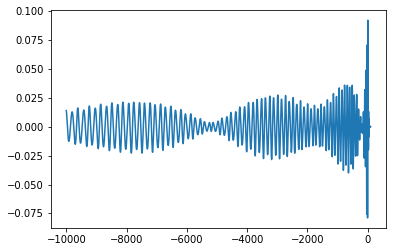

In [14]:
# plt.plot(StoM(hp.sample_times, total_mass), hp)
plt.plot(new_times_M, hp)

In [15]:
X = new_times_M[:, np.newaxis]
y = hp[:, np.newaxis]

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
# Xs_train, Xs_test, ys_train, ys_test = train_test_split(X[200:], y[200:], test_size=0.33, random_state=42)
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_scaler = MinMaxScaler(feature_range=(-0.5, 0.5))
y_scaler = MinMaxScaler(feature_range=(-0.5, 0.5))

# X_scaled = X_scaler.fit_transform(X)
X_scaled = X.copy()
# y_scaled = y_scaler.fit_transform(y)
y_scaled = y.copy()



# Xs_train = X_scaled[::2]
# ys_train = y_scaled[::2]
# Xs_test = X_scaled[1::2]
# ys_test = y_scaled[1::2]

# define model

In [19]:
class DeepResNet(tf.keras.Model):
  """Defines a multi-layer residual network."""
  def __init__(self, num_output=1, num_layers=3, num_hidden=128):
    super().__init__()
    # Defines class meta data.
    self.num_hidden = num_hidden
    self.num_layers = num_layers

    # rff layer
    # gaussian_projection = 64
    # gaussian_projection = 128
    # gaussian_scale = 16
    gaussian_projection = 128
    gaussian_scale = 0.03385/10


    # Defines the hidden layers.
    # self.input_layer = tf.keras.layers.Dense(self.num_hidden, trainable=False)
    self.input_layer = FourierFeatureProjection(
                gaussian_projection=gaussian_projection,
                gaussian_scale=gaussian_scale,
    )
    self.dense_layers = [self.make_dense_layer() for _ in range(num_layers)]

    # Defines the output layer.
    self.classifier = self.make_output_layer(num_output)

  def call(self, inputs):
    # Projects the 2d input data to high dimension.
    hidden = self.input_layer(inputs)

    # Computes the resnet hidden representations.
    for i in range(self.num_layers):
      resid = self.dense_layers[i](hidden)
      hidden += resid

    return self.classifier(hidden)

  def make_dense_layer(self):
    """Uses the Dense layer as the hidden layer."""
    return tf.keras.layers.Dense(self.num_hidden, activation="relu")

  def make_output_layer(self, num_output):
    """Uses the Dense layer as the output layer."""
    return tf.keras.layers.Dense(num_output)

In [20]:
# resnet_config = dict(num_output=1, num_layers=6, num_hidden=128)
resnet_config = dict(num_output=1, num_layers=6, num_hidden=256)

In [21]:
resnet_model = DeepResNet(**resnet_config)

In [22]:
resnet_model.build((None, 1))
resnet_model.summary()

Model: "deep_res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fourier_feature_projection   multiple                 128       
 (FourierFeatureProjection)                                      
                                                                 
 dense (Dense)               multiple                  65792     
                                                                 
 dense_1 (Dense)             multiple                  65792     
                                                                 
 dense_2 (Dense)             multiple                  65792     
                                                                 
 dense_3 (Dense)             multiple                  65792     
                                                                 
 dense_4 (Dense)             multiple                  65792     
                                                      

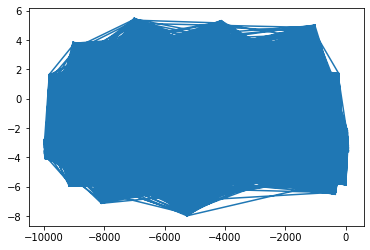

In [23]:
# prior
plt.plot(Xs_train, resnet_model(Xs_train))


In [24]:
import math
total_number_of_points = Xs_train.shape[0]
print(f"total_number_of_points (training): {total_number_of_points}")

batch_size = 128

# https://www.tensorflow.org/addons/tutorials/optimizers_cyclicallearningrate
# steps_per_epoch = len(X_train) // batch_size
steps_per_epoch = math.ceil(total_number_of_points / batch_size)
# steps_per_epoch is the number of mini-batches per epoch
print(f"steps_per_epoch: {steps_per_epoch}")

n_cycles_per_epoch = 10
# n_cycles_per_epoch = 1

# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/CosineDecayRestarts1
lrs = tf.keras.optimizers.schedules.CosineDecayRestarts(
#     1e-4,
    1e-3,
    # 500*5,
    # 5,
    steps_per_epoch/n_cycles_per_epoch,
#     t_mul=2.0,
    t_mul=1.5,
#     t_mul=1.,
#     m_mul=1.,
    m_mul=0.9,
    alpha=0.0,
    name=None
)

total_number_of_points (training): 27068
steps_per_epoch: 212


In [25]:
loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=lrs)

train_config = dict(loss=loss, optimizer=optimizer)

In [26]:
fit_config = dict(batch_size=batch_size, epochs=190)

In [27]:
%%time
resnet_model.compile(**train_config)
resnet_history = resnet_model.fit(Xs_train, ys_train, validation_data=(Xs_test, ys_test), **fit_config)

Epoch 1/190
212/212 [==============================] - 4s 11ms/step - loss: 4.6263 - val_loss: 0.0076
Epoch 2/190
212/212 [==============================] - 2s 9ms/step - loss: 0.0044 - val_loss: 0.0024
Epoch 3/190
212/212 [==============================] - 2s 9ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 4/190
212/212 [==============================] - 1s 4ms/step - loss: 8.2919e-04 - val_loss: 5.6725e-04
Epoch 5/190
212/212 [==============================] - 1s 5ms/step - loss: 4.7206e-04 - val_loss: 4.8080e-04
Epoch 6/190
212/212 [==============================] - 1s 5ms/step - loss: 3.4569e-04 - val_loss: 2.7279e-04
Epoch 7/190
212/212 [==============================] - 1s 4ms/step - loss: 2.1659e-04 - val_loss: 2.0873e-04
Epoch 8/190
212/212 [==============================] - 1s 5ms/step - loss: 1.9055e-04 - val_loss: 1.8511e-04
Epoch 9/190
212/212 [==============================] - 1s 4ms/step - loss: 1.3947e-04 - val_loss: 1.2391e-04
Epoch 10/190
212/212 [====================

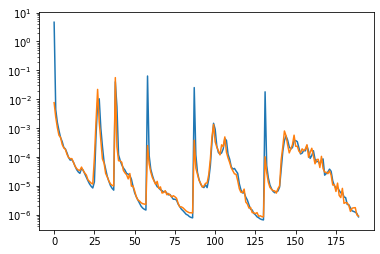

In [28]:
plt.figure()
plt.plot(resnet_history.history['loss'])
plt.plot(resnet_history.history['val_loss'])
plt.yscale('log')

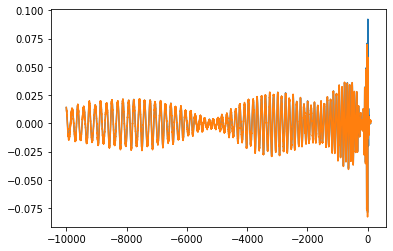

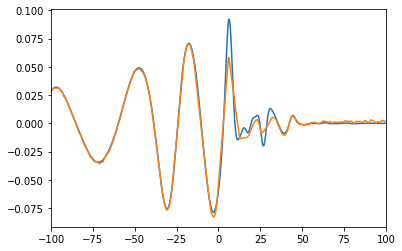

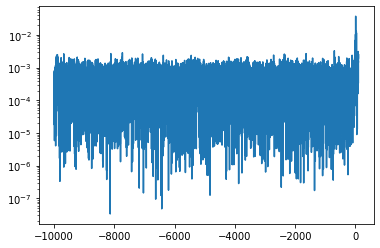

In [29]:
plt.figure()
plt.plot(X_scaled, y_scaled)
plt.plot(X_scaled, resnet_model(X_scaled))

plt.figure()
plt.plot(X, y_scaled)
plt.plot(X, resnet_model(X_scaled))
plt.xlim(-100, 100)

plt.figure()
plt.plot(X_scaled, np.abs(y_scaled-resnet_model(X_scaled)))
plt.yscale('log')

## sngp

In [30]:
class DeepResNetSNGP(DeepResNet):
  def __init__(self, spec_norm_bound=0.9, **kwargs):
    self.spec_norm_bound = spec_norm_bound
    super().__init__(**kwargs)

  def make_dense_layer(self):
    """Applies spectral normalization to the hidden layer."""
    dense_layer = super().make_dense_layer()
    return nlp_layers.SpectralNormalization(
        dense_layer, norm_multiplier=self.spec_norm_bound)

  def make_output_layer(self, num_output):
    """Uses Gaussian process as the output layer."""
    return nlp_layers.RandomFeatureGaussianProcess(
        num_output, 
        gp_cov_momentum=-1)

  def call(self, inputs, training=False, return_covmat=False):
    # Gets logits and covariance matrix from GP layer.
    logits, covmat = super().call(inputs)

    # Returns only logits during training.
    if not training and return_covmat:
      return logits, covmat

    return logits

In [31]:
resnet_config

{'num_output': 1, 'num_layers': 6, 'num_hidden': 256}

In [32]:
sngp_model = DeepResNetSNGP(**resnet_config)

In [33]:
sngp_model.build((None, 1))
sngp_model.summary()

Model: "deep_res_net_sngp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fourier_feature_projection_  multiple                 128       
 1 (FourierFeatureProjection                                     
 )                                                               
                                                                 
 spectral_normalization (Spe  multiple                 66304     
 ctralNormalization)                                             
                                                                 
 spectral_normalization_1 (S  multiple                 66304     
 pectralNormalization)                                           
                                                                 
 spectral_normalization_2 (S  multiple                 66304     
 pectralNormalization)                                           
                                                 

In [34]:
class ResetCovarianceCallback(tf.keras.callbacks.Callback):

  def on_epoch_begin(self, epoch, logs=None):
    """Resets covariance matrix at the begining of the epoch."""
    if epoch > 0:
      self.model.classifier.reset_covariance_matrix()

In [35]:
class DeepResNetSNGPWithCovReset(DeepResNetSNGP):
  def fit(self, *args, **kwargs):
    """Adds ResetCovarianceCallback to model callbacks."""
    kwargs["callbacks"] = list(kwargs.get("callbacks", []))
    kwargs["callbacks"].append(ResetCovarianceCallback())

    return super().fit(*args, **kwargs)

In [36]:
import math
total_number_of_points = Xs_train.shape[0]
print(f"total_number_of_points (training): {total_number_of_points}")

batch_size = 128

# https://www.tensorflow.org/addons/tutorials/optimizers_cyclicallearningrate
# steps_per_epoch = len(X_train) // batch_size
steps_per_epoch = math.ceil(total_number_of_points / batch_size)
# steps_per_epoch is the number of mini-batches per epoch
print(f"steps_per_epoch: {steps_per_epoch}")

n_cycles_per_epoch = 10
# n_cycles_per_epoch = 1

# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/CosineDecayRestarts1
lrs = tf.keras.optimizers.schedules.CosineDecayRestarts(
#     1e-4,
    1e-3,
    # 500*5,
    # 5,
    steps_per_epoch/n_cycles_per_epoch,
#     t_mul=2.0,
    t_mul=1.5,
#     t_mul=1.,
#     m_mul=1.,
    m_mul=0.9,
    alpha=0.0,
    name=None
)

total_number_of_points (training): 27068
steps_per_epoch: 212


In [37]:
loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=lrs)

train_config = dict(loss=loss, optimizer=optimizer)

In [38]:

fit_config={'batch_size': batch_size, 'epochs': 190}


# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=50, min_lr=1e-6)
# callbacks = [reduce_lr]
# fit_config.update({'callbacks':callbacks})

In [39]:
%%time
sngp_model = DeepResNetSNGPWithCovReset(**resnet_config)
sngp_model.compile(**train_config)
sngp_history = sngp_model.fit(Xs_train, ys_train, validation_data=(Xs_test, ys_test), **fit_config)

Epoch 1/190
212/212 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 5.4939e-04
Epoch 2/190
212/212 [==============================] - 1s 6ms/step - loss: 2.4646e-04 - val_loss: 3.8931e-05
Epoch 3/190
212/212 [==============================] - 1s 7ms/step - loss: 5.0532e-05 - val_loss: 6.3128e-06
Epoch 4/190
212/212 [==============================] - 1s 6ms/step - loss: 1.0998e-05 - val_loss: 5.1909e-06
Epoch 5/190
212/212 [==============================] - 1s 6ms/step - loss: 1.6859e-06 - val_loss: 2.1193e-06
Epoch 6/190
212/212 [==============================] - 1s 7ms/step - loss: 4.2932e-06 - val_loss: 2.3833e-06
Epoch 7/190
212/212 [==============================] - 1s 6ms/step - loss: 9.5400e-07 - val_loss: 3.9409e-07
Epoch 8/190
212/212 [==============================] - 1s 7ms/step - loss: 1.5840e-06 - val_loss: 6.7822e-06
Epoch 9/190
212/212 [==============================] - 1s 6ms/step - loss: 5.9675e-06 - val_loss: 2.0360e-06
Epoch 10/190
212/212 [=

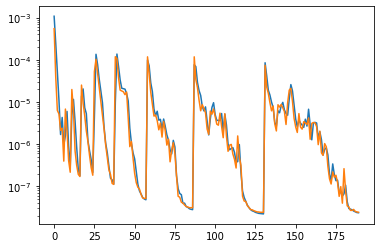

In [40]:
plt.figure()
plt.plot(sngp_history.history['loss'])
plt.plot(sngp_history.history['val_loss'])
plt.yscale('log')

In [41]:

X_scaled.shape

(40400, 1)

In [42]:
Xs_train.shape

(27068, 1)

In [43]:
%%time
# sngp_mean = sngp_model(X, return_covmat=False)
sngp_mean = sngp_model(X_scaled, return_covmat=False)
# sngp_mean = sngp_model(Xs_train, return_covmat=False)

CPU times: user 674 ms, sys: 375 ms, total: 1.05 s
Wall time: 3.46 s


In [44]:
%%time
# sngp_mean, sngp_covmat = sngp_model(X_scaled, return_covmat=True)
sngp_mean, sngp_covmat = sngp_model(X, return_covmat=True)
# sngp_mean, sngp_covmat = sngp_model(Xs_train, return_covmat=True)

CPU times: user 112 ms, sys: 22 ms, total: 134 ms
Wall time: 1.03 s


In [45]:
sngp_mean.shape

TensorShape([40400, 1])

In [46]:
sngp_covmat.shape

TensorShape([40400, 40400])

In [47]:
sngp_variance = tf.linalg.diag_part(sngp_covmat)[:, None]

# std_dev = np.sqrt(np.diag(sngp_covmat))

# std_dev = tf.sqrt(sngp_variance)[:,0]/20
std_dev = sngp_variance[:,0]/5

In [48]:
sngp_variance.shape

TensorShape([40400, 1])

In [49]:
std_dev.shape

TensorShape([40400])

(-100.0, 100.0)

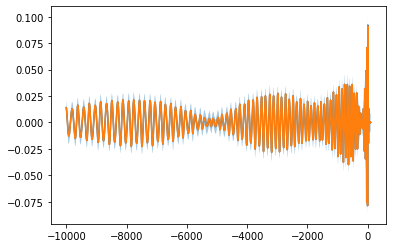

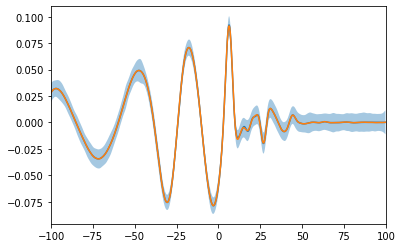

In [50]:
plt.figure()
plt.plot(X, y_scaled)
plt.plot(X, sngp_mean)

plt.fill_between(X[:,0], sngp_mean[:,0] - (std_dev), sngp_mean[:,0] + (std_dev), alpha=0.4)

plt.figure()
plt.plot(X, y_scaled)
plt.plot(X, sngp_mean)

plt.fill_between(X[:,0], sngp_mean[:,0] - (std_dev), sngp_mean[:,0] + (std_dev), alpha=0.4)

plt.xlim(-100, 100)

Text(0.5, 0.0, 't/M')

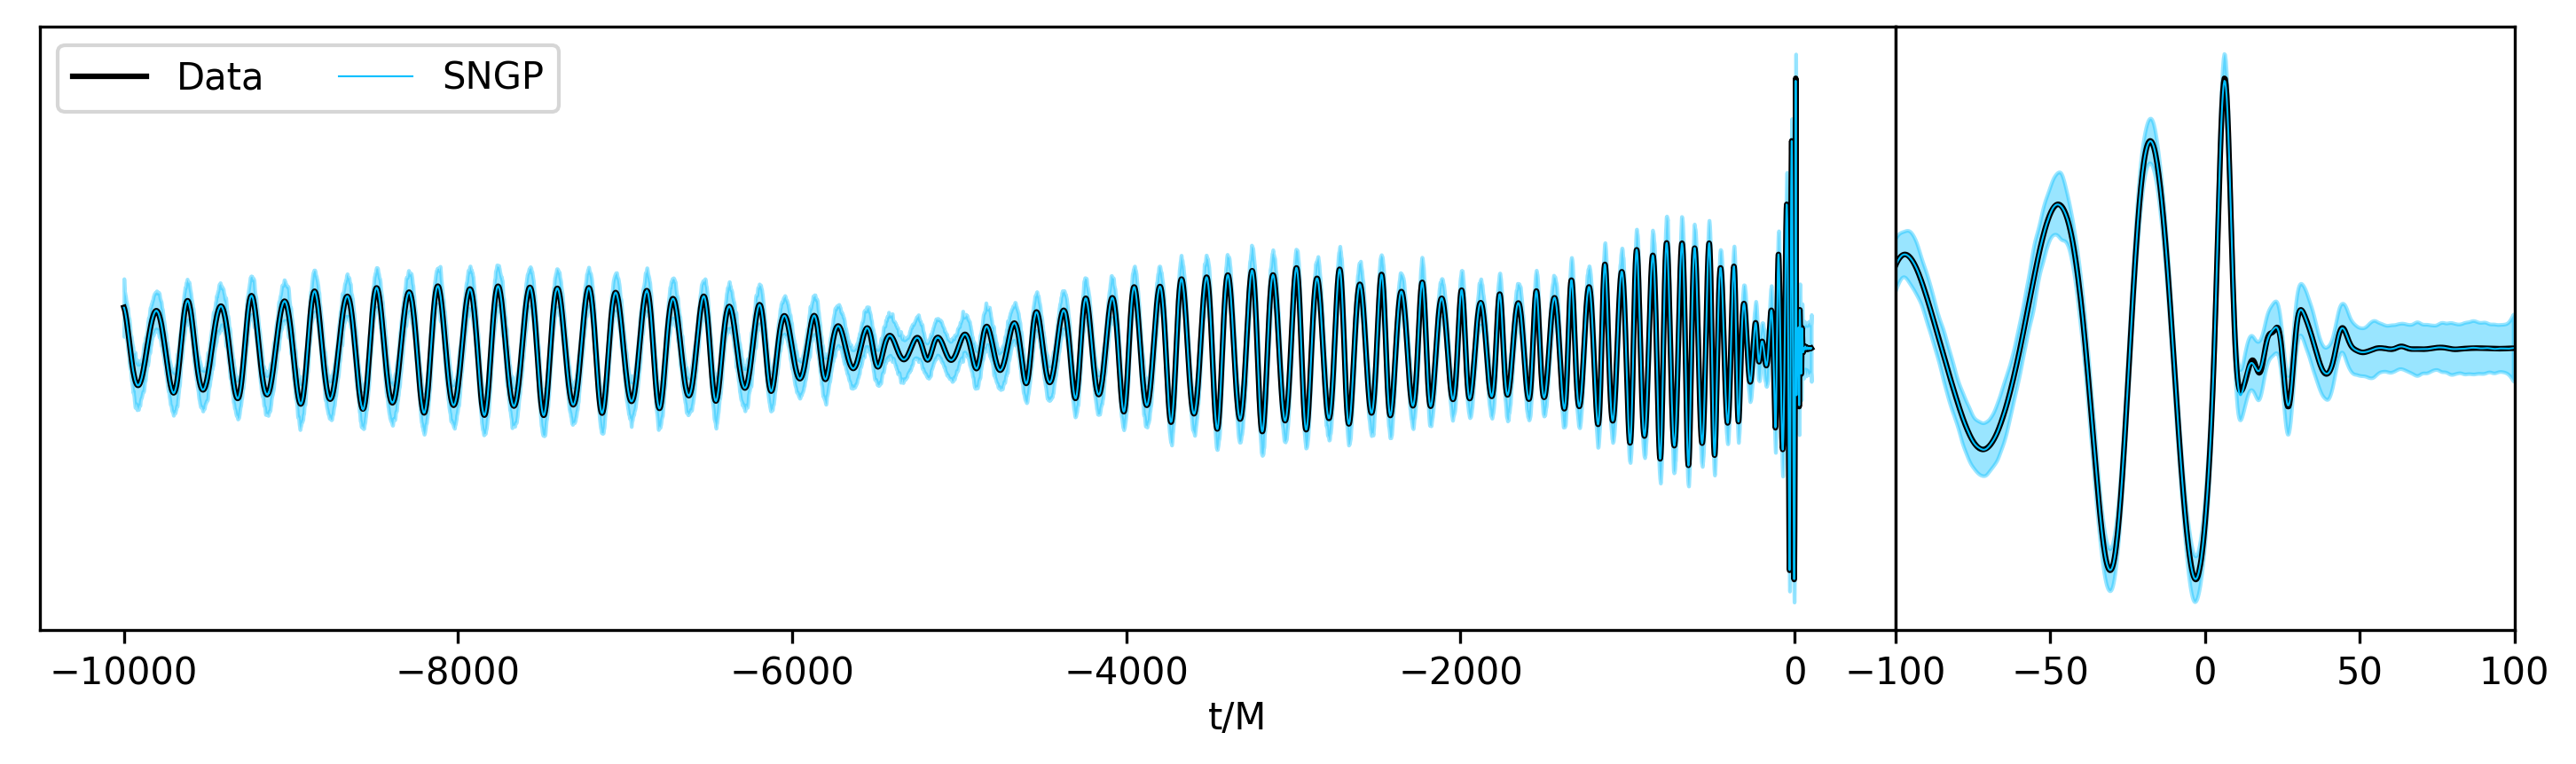

In [51]:
fig = plt.figure(figsize=(12, 3), dpi=300)
grid = plt.GridSpec(1, 4, wspace=0., hspace=0.3, figure=fig)
plt.subplot(grid[0, :3])
plt.plot(X, y_scaled, label='Data', c='k')
# plt.plot(Xs_test, ys_test, 'o')
plt.plot(X, sngp_mean, label='SNGP', ls='-', c='deepskyblue', lw=0.5)
plt.fill_between(X[:,0], sngp_mean[:,0] - (std_dev), sngp_mean[:,0] + (std_dev), alpha=0.4, color='deepskyblue')
plt.legend(ncol=2)
plt.yticks([])

plt.subplot(grid[0, 3]);
plt.plot(X, y_scaled, c='k')
# plt.plot(Xs_test, ys_test, 'o', markersize=3)
plt.plot(X, sngp_mean, ls='-', c='deepskyblue', lw=0.5)
plt.fill_between(X[:,0], sngp_mean[:,0] - (std_dev), sngp_mean[:,0] + (std_dev), alpha=0.4, color='deepskyblue')
plt.xlim(-100, 100)
plt.yticks([])

fig.text(0.5, 0.0, 't/M', ha='center')

In [63]:

std_dev.shape

TensorShape([40400])

In [52]:
sngp_mean.shape

TensorShape([40400, 1])

In [53]:

sngp_covmat.shape

TensorShape([40400, 40400])

In [54]:
# plt.imshow(sngp_covmat)

In [55]:
# y_samples = np.random.multivariate_normal(sngp_mean[:,0], sngp_covmat, 2)

In [56]:
# y_samples.shape

In [57]:
# for y_sample in y_samples:
#     plt.plot(X, y_sample)

In [58]:
X.shape

(40400, 1)

In [59]:
sngp_mean.shape

TensorShape([40400, 1])

In [64]:
out = np.column_stack((X[:,0], sngp_mean[:,0], std_dev))
np.save("sngp.npy", out)

In [66]:
y_scaled.shape

(40400, 1)

In [67]:
out = np.column_stack((X[:,0], y_scaled[:,0]))
np.save("sngp_data.npy", out)

In [61]:
plain_ty = np.load("plain.npy")

In [62]:
plain_ty.shape

(20200, 2)

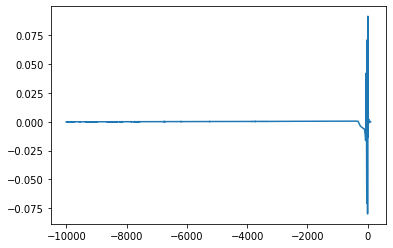

In [68]:
plt.plot(plain_ty[:,0], plain_ty[:,1])

Text(0.5, 0.0, 't/M')

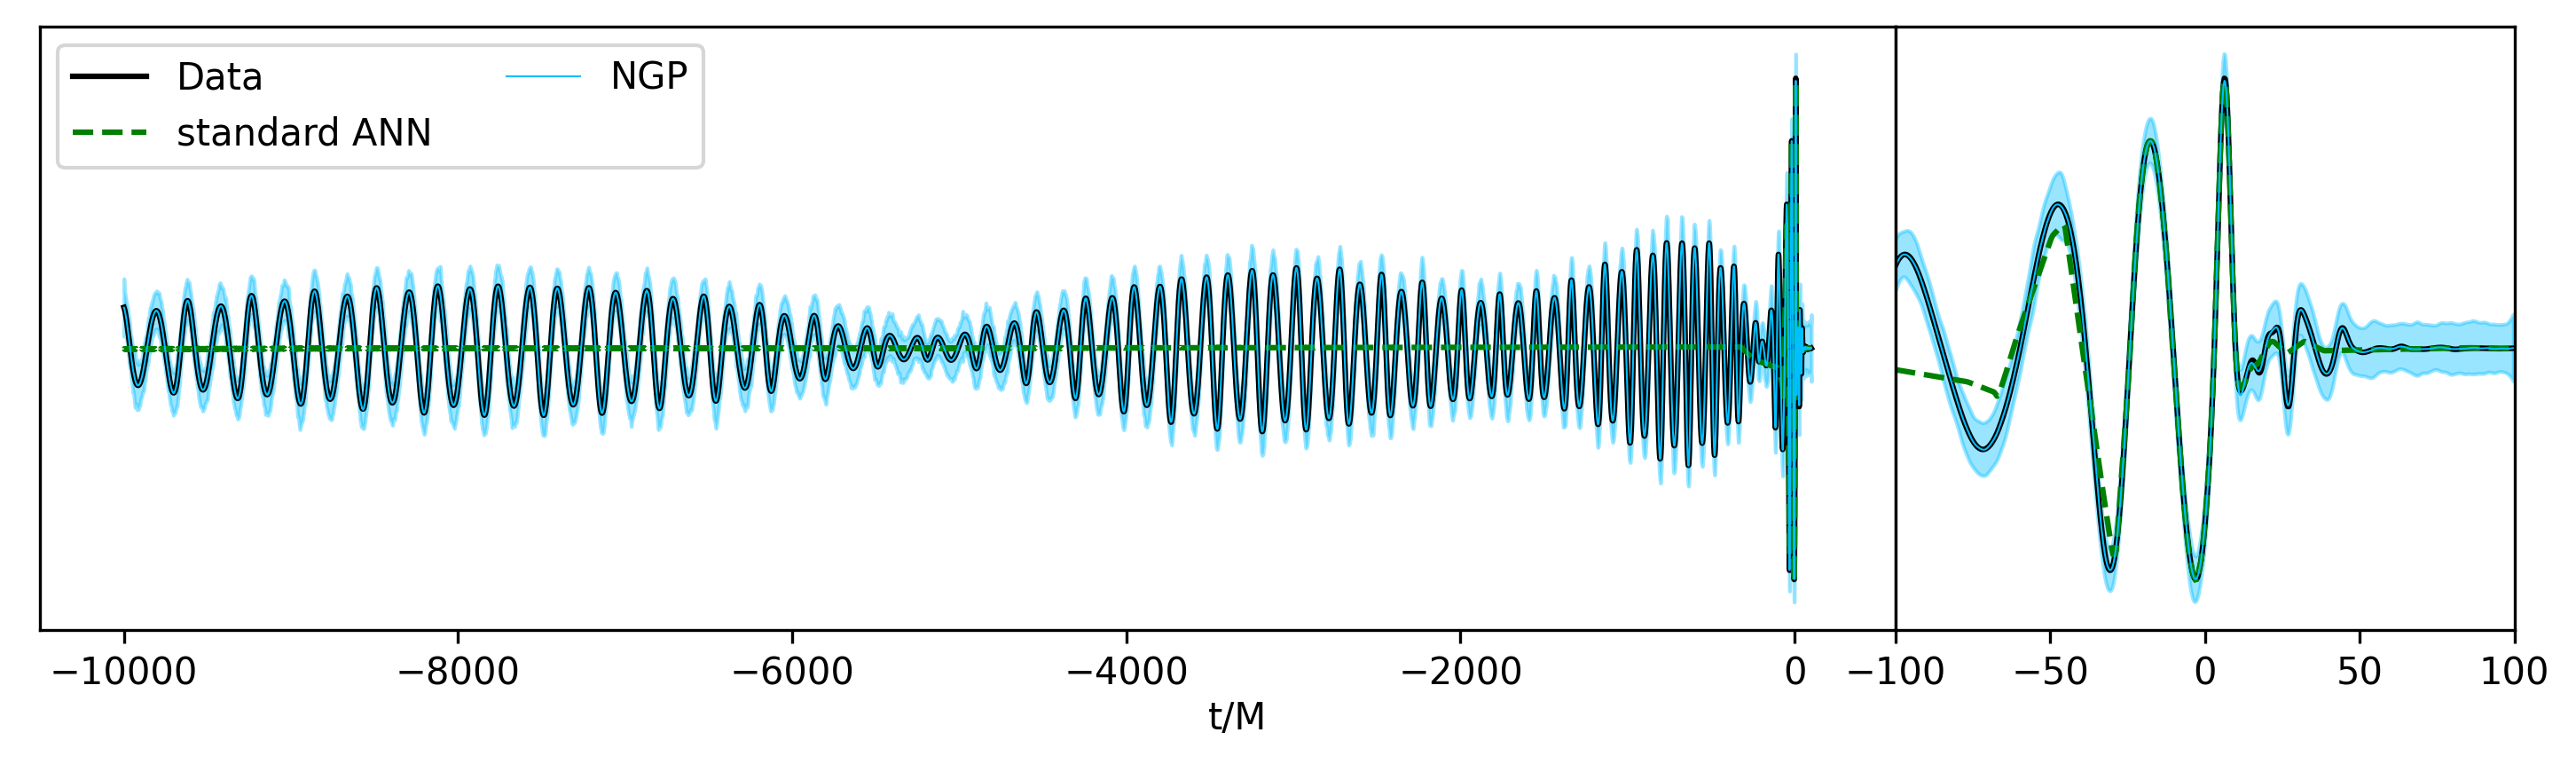

In [73]:
fig = plt.figure(figsize=(12, 3), dpi=300)
grid = plt.GridSpec(1, 4, wspace=0., hspace=0.3, figure=fig)
plt.subplot(grid[0, :3])
plt.plot(X, y_scaled, label='Data', c='k')
# plt.plot(Xs_test, ys_test, 'o')
plt.plot(plain_ty[:,0], plain_ty[:,1], 'g--', label='standard ANN')
plt.plot(X, sngp_mean, label='NGP', ls='-', c='deepskyblue', lw=0.5)
plt.fill_between(X[:,0], sngp_mean[:,0] - (std_dev), sngp_mean[:,0] + (std_dev), alpha=0.4, color='deepskyblue')

plt.legend(ncol=2)
plt.yticks([])

plt.subplot(grid[0, 3]);
plt.plot(X, y_scaled, c='k')
# plt.plot(Xs_test, ys_test, 'o', markersize=3)
plt.plot(plain_ty[:,0], plain_ty[:,1], 'g--')
plt.plot(X, sngp_mean, ls='-', c='deepskyblue', lw=0.5)
plt.fill_between(X[:,0], sngp_mean[:,0] - (std_dev), sngp_mean[:,0] + (std_dev), alpha=0.4, color='deepskyblue')

plt.xlim(-100, 100)
plt.yticks([])

fig.text(0.5, 0.0, 't/M', ha='center')